# 04 — Machine Learning Model Training (Late vs Not-late Prediction)

ในสมุดบันทึกนี้ เราจะทำการสร้างโมเดล Machine Learning เพื่อตอบคำถาม:

> “เราสามารถทำนายได้หรือไม่ว่าเรื่องร้องเรียนของ Traffy Fondue จะ **เสร็จช้า (late)** หรือ **เสร็จตามเวลา**?”

## สิ่งที่จะทำใน notebook นี้

1. โหลด Feature dataset (`traffy_features.csv`)
2. แยก **features (X)** และ **target (y = is_late)**
3. สร้าง **ML Pipeline** ประกอบด้วย
   - Imputer สำหรับ missing values
   - OneHotEncoder สำหรับ categorical
   - StandardScaler สำหรับ numeric
4. Train/Test Split
5. โมเดลที่ใช้:
   - RandomForestClassifier (baseline)
6. Evaluation:
   - Accuracy
   - F1-score
   - Confusion matrix
7. Feature importance
8. เซฟโมเดลเป็น `.joblib`

ผลสุดท้ายจะพร้อมใช้ในการ deploy หรือการอธิบายในรายงาน


In [1]:
import os
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

# Paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
FEATURE_DIR = os.path.join(DATA_DIR, "features")

FEATURE_FILE = os.path.join(FEATURE_DIR, "traffy_features.csv")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

In [2]:
df = pd.read_csv(FEATURE_FILE)
print("Loaded:", df.shape)
df.head()

Loaded: (300002, 19)


,type,organization,district,lat,lon,star,count_reopen,hour,dayofweek,month,year,num_hospitals_in_district,rain_mm,is_rainy_hour,rain_last_3h,temperature,high_temperature,wind_speed,is_late
0,{ความสะอาด},เขตบางซื่อ,NaN,100.53084,13.81865,0.0,0,12,4,9,2021,0,0.0,0,0.0,NaN,0,NaN,1
1,"{น้ำท่วม,ถนน}","เขตลาดพร้าว,ฝ่ายโยธา เขตลาดพร้าว",ลาดพร้าว,100.59165,13.82280,5.0,0,12,3,12,2021,2,0.0,0,0.0,NaN,0,NaN,1
2,{},"เขตลาดพร้าว,การไฟฟ้านครหลวง เขตนวลจันทร์",ลาดพร้าว,100.59131,13.80910,0.0,0,5,0,12,2021,2,0.0,0,0.0,NaN,0,NaN,1
3,{ท่อระบายน้ำ},"เขตประเวศ,ฝ่ายโยธา เขตประเวศ",ประเวศ,100.65440,13.68158,5.0,0,10,2,12,2021,4,0.0,0,0.0,NaN,0,NaN,1
4,"{ถนน,ทางเท้า}","เขตสาทร,ฝ่ายโยธา เขตสาทร",สาทร,100.53764,13.70716,0.0,0,10,6,1,2022,2,0.0,0,0.0,NaN,0,NaN,1


In [3]:
target = "is_late"

# X = all columns except target
X = df.drop(columns=[target])
y = df[target]

print(X.shape, y.shape)
X.head()

(300002, 18) (300002,)


,type,organization,district,lat,lon,star,count_reopen,hour,dayofweek,month,year,num_hospitals_in_district,rain_mm,is_rainy_hour,rain_last_3h,temperature,high_temperature,wind_speed
0,{ความสะอาด},เขตบางซื่อ,NaN,100.53084,13.81865,0.0,0,12,4,9,2021,0,0.0,0,0.0,NaN,0,NaN
1,"{น้ำท่วม,ถนน}","เขตลาดพร้าว,ฝ่ายโยธา เขตลาดพร้าว",ลาดพร้าว,100.59165,13.82280,5.0,0,12,3,12,2021,2,0.0,0,0.0,NaN,0,NaN
2,{},"เขตลาดพร้าว,การไฟฟ้านครหลวง เขตนวลจันทร์",ลาดพร้าว,100.59131,13.80910,0.0,0,5,0,12,2021,2,0.0,0,0.0,NaN,0,NaN
3,{ท่อระบายน้ำ},"เขตประเวศ,ฝ่ายโยธา เขตประเวศ",ประเวศ,100.65440,13.68158,5.0,0,10,2,12,2021,4,0.0,0,0.0,NaN,0,NaN
4,"{ถนน,ทางเท้า}","เขตสาทร,ฝ่ายโยธา เขตสาทร",สาทร,100.53764,13.70716,0.0,0,10,6,1,2022,2,0.0,0,0.0,NaN,0,NaN


In [4]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

Numeric: ['lat', 'lon', 'star', 'count_reopen', 'hour', 'dayofweek', 'month', 'year', 'num_hospitals_in_district', 'rain_mm', 'is_rainy_hour', 'rain_last_3h', 'temperature', 'high_temperature', 'wind_speed']
Categorical: ['type', 'organization', 'district']


In [5]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [6]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((240001, 18), (60001, 18))

In [8]:
clf.fit(X_train, y_train)
print("Training complete.")

Training complete.


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     28257
           1       0.76      0.78      0.77     31744

    accuracy                           0.75     60001
   macro avg       0.75      0.75      0.75     60001
weighted avg       0.75      0.75      0.75     60001



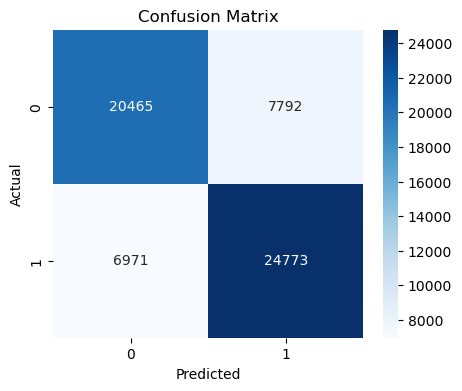

In [9]:
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# get feature names
ohe = clf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
ohe_features = ohe.get_feature_names_out(categorical_cols)

all_features = np.concatenate([numeric_cols, ohe_features])

importances = clf.named_steps["model"].feature_importances_

feat_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_df.head(20)

,feature,importance
0,lat,0.080022
1,lon,0.077492
4,hour,0.058101
6,month,0.055883
5,dayofweek,0.045575
7,year,0.029865
14,wind_speed,0.025238
12,temperature,0.025158
2,star,0.025085
3,count_reopen,0.018699


/home/frostnzx/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/frostnzx/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/frostnzx/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/frostnzx/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/frostnzx/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) mis

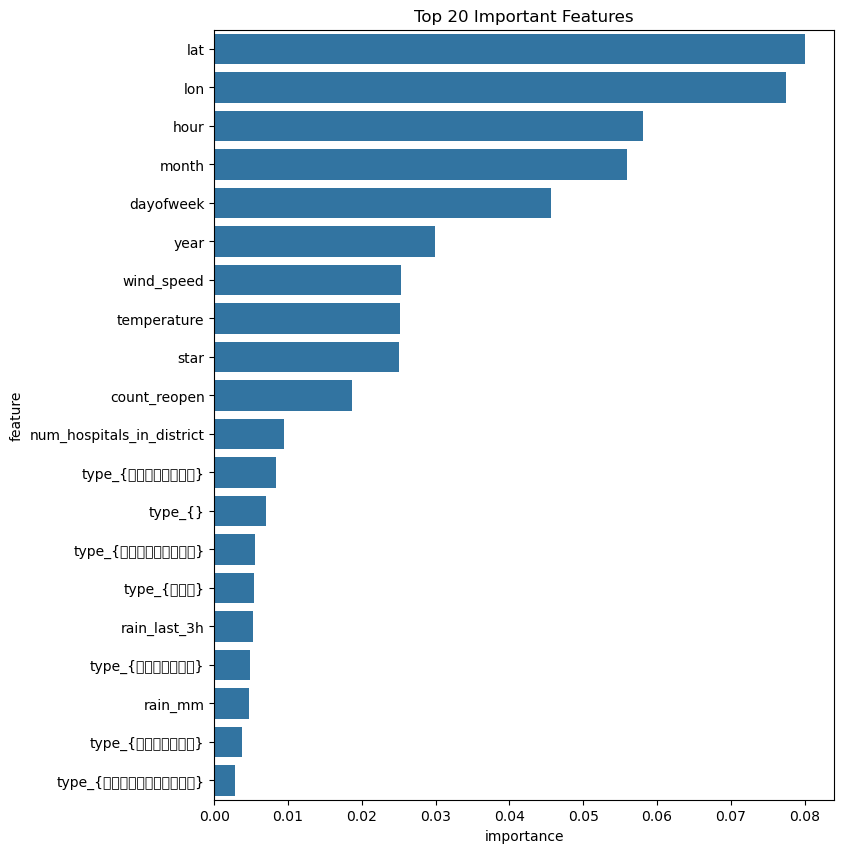

In [11]:
plt.figure(figsize=(8,10))
sns.barplot(data=feat_df.head(20), x="importance", y="feature")
plt.title("Top 20 Important Features")
plt.show()

In [12]:
model_path = os.path.join(MODEL_DIR, "traffy_rf_model.joblib")
joblib.dump(clf, model_path)

print("Model saved to:", model_path)

Model saved to: /home/frostnzx/uniworks/datasci/final_project/models/traffy_rf_model.joblib


In [13]:
# Batch prediction on the entire dataset used for training
df["pred_is_late"] = clf.predict(X)
df["pred_proba_late"] = clf.predict_proba(X)[:, 1]

# Save output for Power BI
out_path = "../data/predictions/traffy_with_predictions.csv"
os.makedirs("../data/predictions", exist_ok=True)
df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("✔ Batch predictions saved to:", out_path)

✔ Batch predictions saved to: ../data/predictions/traffy_with_predictions.csv


# Summary — ML Model Training Completed

สิ่งที่ทำใน `04_ml_training.ipynb`:

1. โหลดฟีเจอร์จาก `traffy_features.csv`
2. แยก X (features) และ y (target = is_late)
3. สร้าง Preprocessing Pipeline:
   - Imputer (numeric/categorical)
   - StandardScaler (numeric)
   - OneHotEncoder (categorical)
4. เทรนโมเดล RandomForestClassifier
5. ประเมินผลด้วย classification report และ confusion matrix
6. วิเคราะห์ feature importance
7. บันทึกโมเดลเป็น `traffy_rf_model.joblib`